<a href="https://www.kaggle.com/code/rohanmudgalkar/playground-season3-e5?scriptVersionId=120888384" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wine-quality-dataset/WineQT.csv
/kaggle/input/playground-series-season-3-episode-5/sample_submission.csv
/kaggle/input/playground-series-season-3-episode-5/train.csv
/kaggle/input/playground-series-season-3-episode-5/test.csv


In [2]:
from time import time
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import math

In [3]:
# Using code from https://www.kaggle.com/code/gemartin/load-data-reduce-memory-usage/notebook

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage, took from Kaggle.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                    
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-season-3-episode-5/train.csv')
train = reduce_mem_usage(train)
test = pd.read_csv('/kaggle/input/playground-series-season-3-episode-5/test.csv')
test = reduce_mem_usage(test)
submission_sample = pd.read_csv('/kaggle/input/playground-series-season-3-episode-5/sample_submission.csv')
original_df = pd.read_csv('/kaggle/input/wine-quality-dataset/WineQT.csv')
original_df = reduce_mem_usage(original_df)

Memory usage of dataframe is 0.20 MB
Memory usage after optimization is: 0.05 MB
Decreased by 75.9%
Memory usage of dataframe is 0.13 MB
Memory usage after optimization is: 0.03 MB
Decreased by 74.9%
Memory usage of dataframe is 0.11 MB
Memory usage after optimization is: 0.03 MB
Decreased by 75.9%


In [5]:
test_df = test.copy()

In [6]:
train.columns
test.columns

train.drop(['Id'],axis=1,inplace=True)
test.drop(['Id'],axis=1,inplace=True)
original_df.drop(['Id'],axis=1,inplace=True)

In [7]:
train.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [8]:
original_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [9]:
# Concatenating train and original dataframes:

train = pd.concat([train, original_df], ignore_index=True)

In [10]:
train.quality.value_counts()

5    1322
6    1240
7     476
4      88
8      55
3      18
Name: quality, dtype: int64

Most of the training records have a quality rating of 5.

## EDA

**Checking correlation**

<AxesSubplot:>

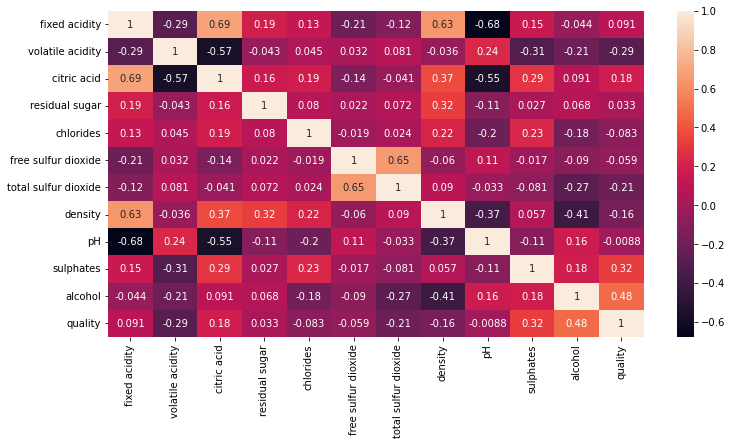

In [11]:
plt.figure(figsize=(12,6))
sns.heatmap(train.corr(), annot=True)

Alcohol seems to have the highest positive correlation with quality followed by sulphates.

**Distribution of the dependent variable:**

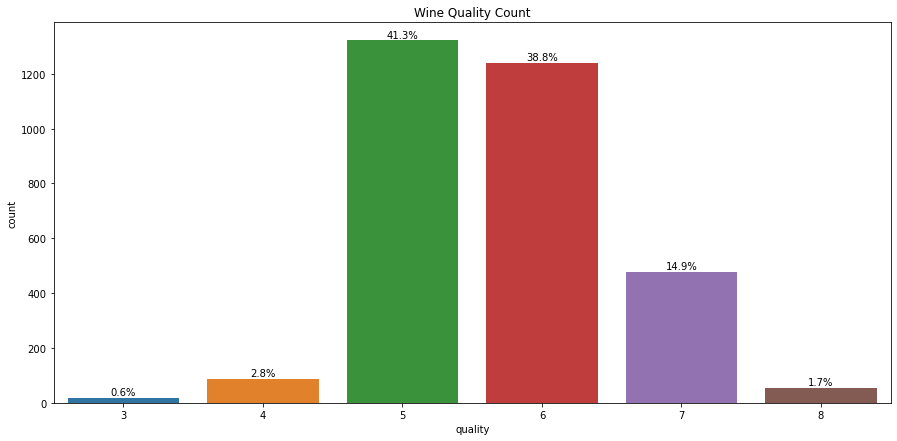

In [12]:
fig, ax = plt.subplots(figsize = (15,7))
sns.countplot(x= train['quality'])
plt.title("Wine Quality Count")

total = len(train)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

**Distribution of each of the variables**

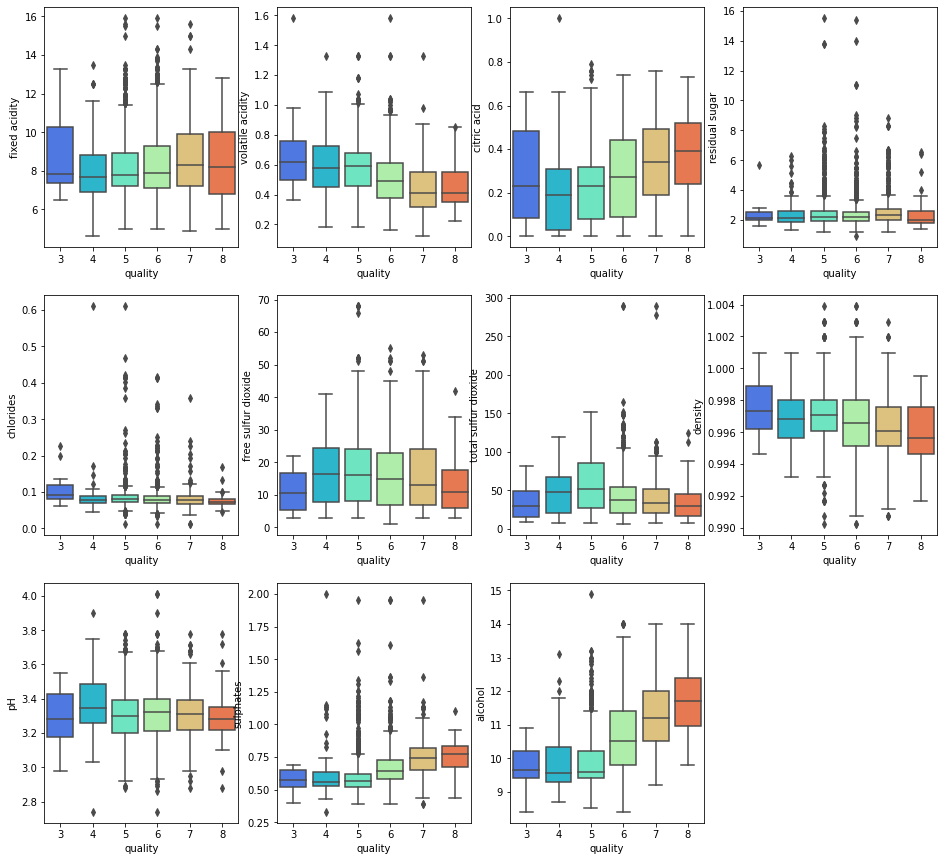

In [13]:
n_cols = 4
n_rows = math.ceil(len(train.columns[:-1])/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()


for i, feature in enumerate(train.columns[:-1]):
    sns.boxplot(x= 'quality' , y=feature, data=train, palette='rainbow', ax=ax[i])

    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    


**Outliers distribution**

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


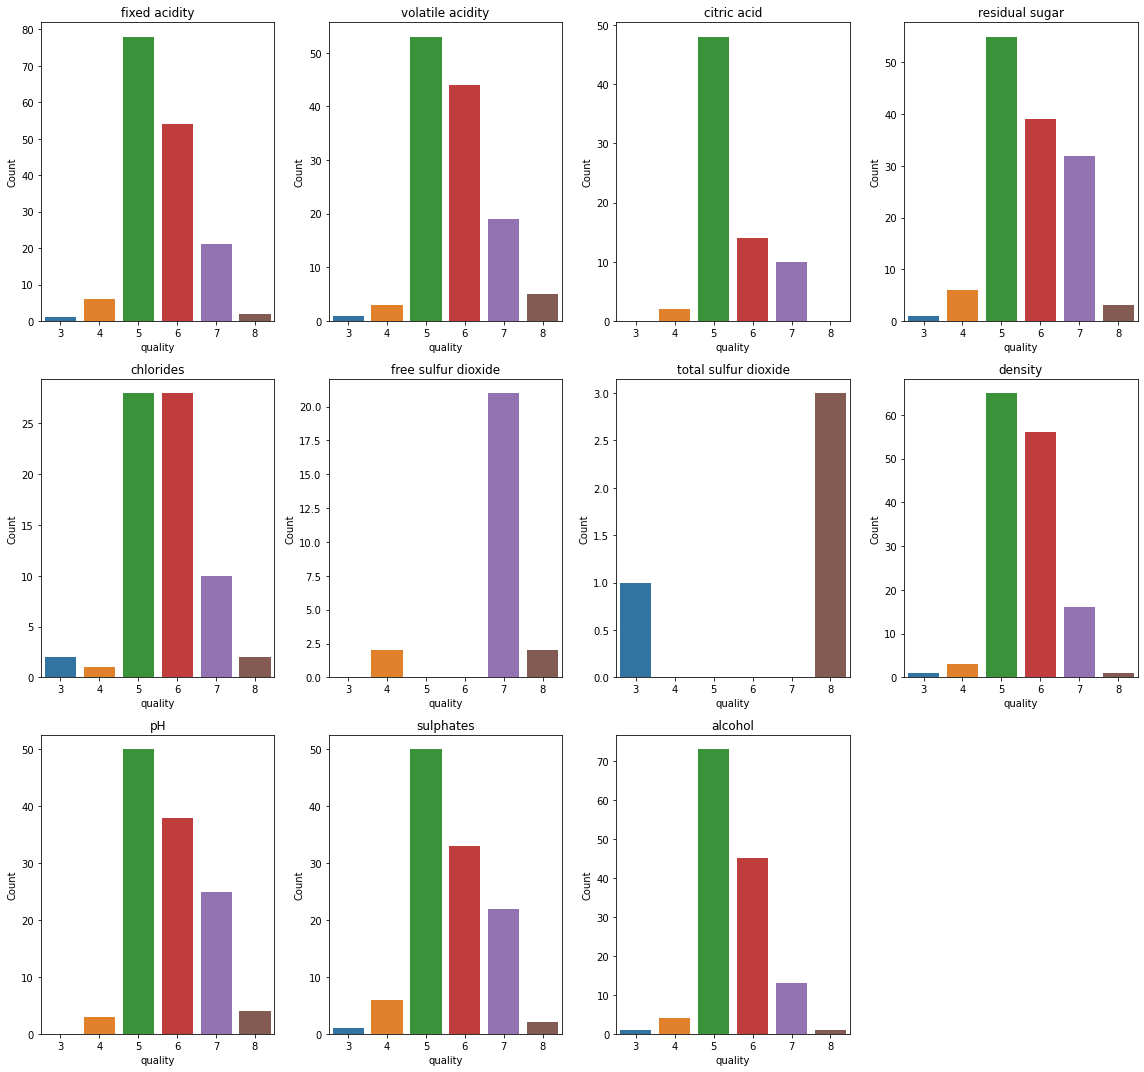

In [14]:
#Referred from https://www.kaggle.com/code/jcaliz/ps-s03e05-a-complete-eda

from scipy.stats import zscore
features = train.columns[:-1]
columns=features
z_scores = train[features]
z_scores = z_scores.groupby(train.quality).apply(zscore)
outliers = z_scores.abs().ge(2).groupby(train.quality).sum()

n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

for i, feature in enumerate(features):
    sns.barplot(x=outliers.index, y=outliers[feature], ax=ax[i])
    ax[i].set_ylabel('Count')
    ax[i].set_title(feature)
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
plt.tight_layout()

## Feature Engineering

In [15]:
# Referenced from https://www.kaggle.com/code/jcaliz/ps-s03e05-a-complete-eda?scriptVersionId=117977228&cellId=23


def add_columns(df):
        df['total_acid'] = df['fixed acidity'] + df['volatile acidity'] + df['citric acid']
        df['acid/density'] = df['total_acid']  / df['density']
        df['alcohol_density'] = df['alcohol']  * df['density']
        df['sulphate/density'] = df['sulphates']  / df['density']
        df['sulphates/acid'] = df['sulphates'] / df['volatile acidity']
        df['sulphates/chlorides'] = df['sulphates'] / df['chlorides']
        df['sulphates*alcohol'] = df['sulphates'] / df['alcohol']

        
add_columns(train)
add_columns(test)

In [16]:
# Moving quality to the end of the dataframe:

cols = list(train.columns.values) 
cols.pop(cols.index('quality')) 
train = train[cols+['quality']]

## Models ##

**1. Light GBM Classifier**

In [17]:
# Referenced from https://www.kaggle.com/code/jcaliz/ps-s03e05-a-complete-eda?scriptVersionId=117977228&cellId=25

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier

cv = StratifiedKFold(5, shuffle=True, random_state=42)
X = train.iloc[:,:-1]
y = train.iloc[:,-1]

kappas = []
test_preds = []
models = []
oof_preds = pd.Series(0, index=train.index)
start = time()

for fold, (tr_ix, vl_ix) in enumerate(cv.split(train, train.quality)):
    start_fold = time()
    X_tr, y_tr = X.loc[tr_ix].copy(), y.loc[tr_ix]
    X_vl, y_vl = X.loc[vl_ix].copy(), y.loc[vl_ix]
    
    model = LGBMClassifier(max_depth=6, random_state=42, class_weight='balanced')
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_vl)
    oof_preds.iloc[vl_ix] = y_pred
    kappas.append(cohen_kappa_score(y_vl, y_pred, weights='quadratic'))
    models.append(model)
    
    print('_' * 30)
    print(f'Fold: {fold} - {timedelta(seconds=int(time()-start))}')
    print(f'Quadratic Kappa  : ', kappas[-1])
    print(f'Train Time taken :  {timedelta(seconds=int(time()-start_fold))}')
    print()
    
print(f'Mean Quadratic Kappa:  {np.mean(kappas)}')

______________________________
Fold: 0 - 0:00:00
Quadratic Kappa  :  0.5138999931470863
Train Time taken :  0:00:00

______________________________
Fold: 1 - 0:00:01
Quadratic Kappa  :  0.4851776997891388
Train Time taken :  0:00:00

______________________________
Fold: 2 - 0:00:02
Quadratic Kappa  :  0.49882163419945713
Train Time taken :  0:00:00

______________________________
Fold: 3 - 0:00:02
Quadratic Kappa  :  0.5458344313518805
Train Time taken :  0:00:00

______________________________
Fold: 4 - 0:00:03
Quadratic Kappa  :  0.5106064654020839
Train Time taken :  0:00:00

Mean Quadratic Kappa:  0.5108680447779295


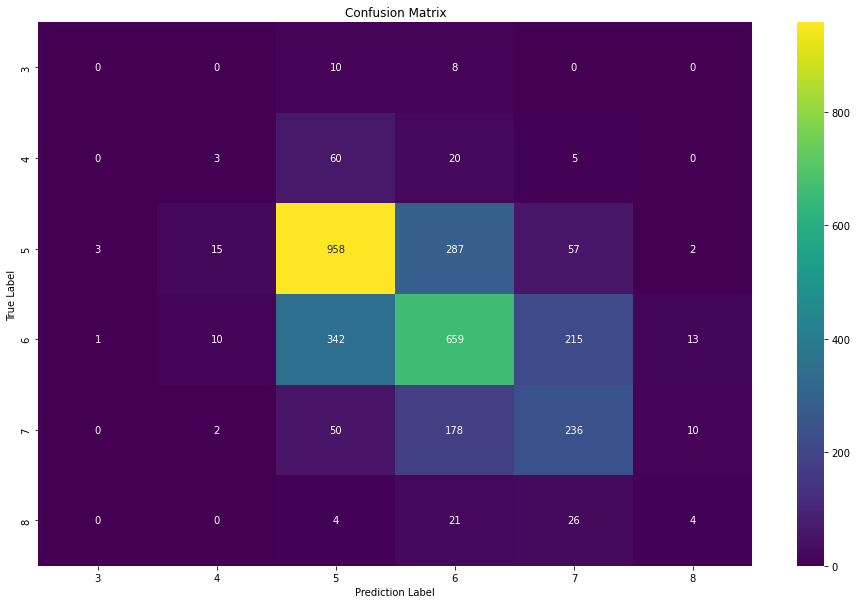

In [18]:
fig, ax = plt.subplots(figsize=(16, 10))

sns.heatmap(
    confusion_matrix(train.quality, oof_preds),
    annot=True,
    cmap='viridis',
    fmt='',
    ax=ax
);

qualities = np.sort(train.quality.unique())
ax.set_xticklabels(qualities)
ax.set_yticklabels(qualities)
ax.set_ylabel('True Label')
ax.set_xlabel('Prediction Label')
ax.set_title('Confusion Matrix');

**2. Light GBM Regressor**

The same problem can be solved using light gbm regressor as well. However, QWK cannot be calculated on continuous variables. Using light GBM rounder wrapper class for using regressor with QWK metric from https://www.kaggle.com/competitions/playground-series-s3e5/discussion/382960.

In [19]:
from lightgbm import LGBMRegressor
import scipy as sp
import numpy as np
from functools import partial
from sklearn.metrics import cohen_kappa_score
qwk = partial(cohen_kappa_score, weights='quadratic')

class LGBMRegressorWithRounder(LGBMRegressor):
    '''
    A light wrapper over LGBMRegressor to deal rounding predictions
    '''
    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 3
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 4
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 5
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 6
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 7
            else:
                X_p[i] = 8

        ll = qwk(y, X_p)
        return -ll

    def fit(self, X, y, **params):
        super().fit(X, y, **params)
        X_pred = super().predict(X)
        loss_partial = partial(self._kappa_loss, X=X_pred, y=y)
        # a little bit of wobble
        initial_coef = list(
            np.array([3.5, 4.5, 5.5, 6.5, 7.5])
        )
        self.round_coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        return self

    def set_params(self, **params):
        self.round_coef_ = None

    def predict_discrete(self, X):
        coef = self.coefficients()
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 3
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 4
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 5
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 6
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 7
            else:
                X_p[i] = 8
        return X_p.astype('int')

    def coefficients(self):
        return self.round_coef_['x']

    def predict(self, X):
        X_pred = super().predict(X)
        return self.predict_discrete(X_pred)

In [20]:
cv = StratifiedKFold(5, shuffle=True, random_state=42)
X = train.iloc[:,:-1]
y = train.iloc[:,-1]

kappas = []
test_preds = []
models = []
oof_preds = pd.Series(0, index=train.index)
start = time()

for fold, (tr_ix, vl_ix) in enumerate(cv.split(train, train.quality)):
    start_fold = time()
    #print(f'tr_ix: {tr_ix} and vl_ix: {vl_ix}')
    X_tr, y_tr = X.loc[tr_ix].copy(), y.loc[tr_ix]
    X_vl, y_vl = X.loc[vl_ix].copy(), y.loc[vl_ix]
    
    model = LGBMRegressorWithRounder(max_depth=4, random_state=42, class_weight='balanced')
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_vl)
    oof_preds.iloc[vl_ix] = y_pred
    kappas.append(cohen_kappa_score(y_vl, y_pred, weights='quadratic'))
    models.append(model)
    
    print('_' * 30)
    print(f'Fold: {fold} - {timedelta(seconds=int(time()-start))}')
    print(f'Quadratic Kappa  : ', kappas[-1])
    print(f'Train Time taken :  {timedelta(seconds=int(time()-start_fold))}')
    print()
    
print(f'Mean Quadratic Kappa:  {np.mean(kappas)}')

______________________________
Fold: 0 - 0:00:01
Quadratic Kappa  :  0.5427421496149922
Train Time taken :  0:00:01

______________________________
Fold: 1 - 0:00:03
Quadratic Kappa  :  0.4881043692171617
Train Time taken :  0:00:02

______________________________
Fold: 2 - 0:00:04
Quadratic Kappa  :  0.4616822429906542
Train Time taken :  0:00:01

______________________________
Fold: 3 - 0:00:06
Quadratic Kappa  :  0.48618996203545684
Train Time taken :  0:00:01

______________________________
Fold: 4 - 0:00:07
Quadratic Kappa  :  0.5436219331864682
Train Time taken :  0:00:01

Mean Quadratic Kappa:  0.5044681314089466


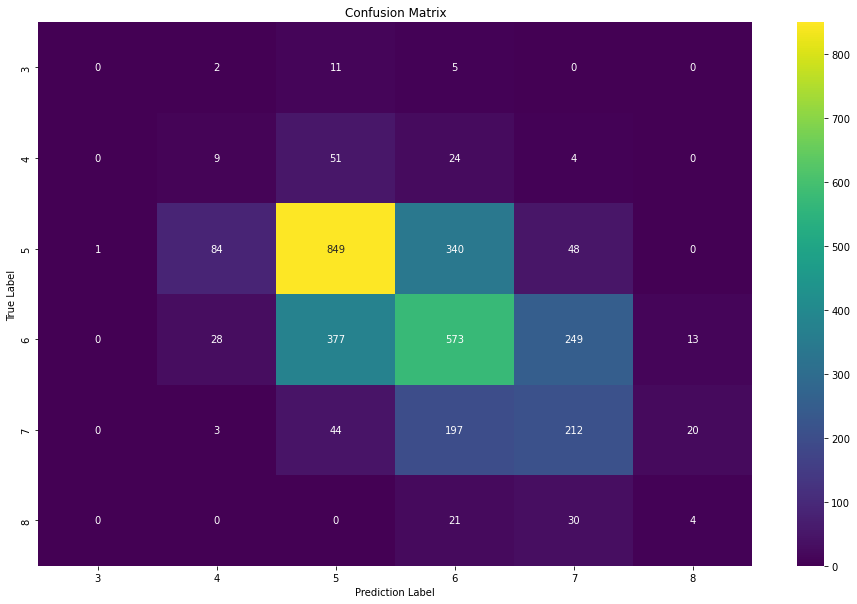

In [21]:
fig, ax = plt.subplots(figsize=(16, 10))

sns.heatmap(
    confusion_matrix(train.quality, oof_preds),
    annot=True,
    cmap='viridis',
    fmt='',
    ax=ax
);

qualities = np.sort(train.quality.unique())
ax.set_xticklabels(qualities)
ax.set_yticklabels(qualities)
ax.set_ylabel('True Label')
ax.set_xlabel('Prediction Label')
ax.set_title('Confusion Matrix');

## Uploading Submission ##

In [22]:
test['quality'] = model.predict(test)
prediction = pd.merge(test, test_df, left_index=True, right_index=True)[['Id','quality']]

In [23]:
prediction.to_csv("submission.csv", index=False)